In [2]:
from ultralytics import YOLO
import numpy as np
import csv
import cv2
import pandas as pd
import matplotlib.pyplot as plt


In [1]:
import csv
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import cv2
import numpy as np

# Load YOLOv8 model
model = YOLO('bestYOLOV8x.pt')
model.to('cuda')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# Load video
# cap = cv2.VideoCapture('0822.mp4')
cap = cv2.VideoCapture('0822.mp4')


# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame_width, frame_height))

# Store the previous positions of tracked objects
previous_positions = {}

# Store tracking data for CSV export
tracking_data = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)
    detections = results[0].boxes.data

    # Prepare detections for DeepSORT
    dets = []
    for box in detections:
        x1, y1, x2, y2, conf, cls = box.cpu().numpy()
        width = x2 - x1
        height = y2 - y1
        dets.append([[x1, y1, width, height], conf])

    # Update tracker with detections
    tracks = tracker.update_tracks(dets, frame=frame)

    # Draw tracking results on the frame
    for track in tracks:
        if track.is_confirmed():
            track_id = track.track_id
            bbox = track.to_tlbr()
            x_center = (bbox[0] + bbox[2]) / 2
            y_center = (bbox[1] + bbox[3]) / 2
            current_position = np.array([x_center, y_center])

            # Calculate velocity if we have previous position
            if track_id in previous_positions:
                previous_position = previous_positions[track_id]
                displacement = np.linalg.norm(current_position - previous_position)  # Euclidean distance
                velocity = displacement * fps  # pixels per second
            else:
                velocity = 0

            # Update previous position
            previous_positions[track_id] = current_position

            # Draw bounding box and velocity
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {track_id}', (int(bbox[0]), int(bbox[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Vel: {velocity:.2f} px/s', (int(bbox[0]), int(bbox[1])-40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Append tracking data to the list for CSV export
            tracking_data.append([cap.get(cv2.CAP_PROP_POS_FRAMES), track_id, x_center, y_center, velocity])

    # Write the frame to the output video file
    out.write(frame)
    # Display the frame (optional)
    cv2.imshow('YOLOv8 with DeepSORT Tracking and Velocity', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

# Write tracking data to a CSV file
with open('MOV.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (px/s)'])
    csvwriter.writerows(tracking_data)



0: 384x640 14 fishs, 70.4ms
Speed: 4.5ms preprocess, 70.4ms inference, 212.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 fishs, 11.6ms
Speed: 4.0ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 11.5ms
Speed: 3.1ms preprocess, 11.5ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 12.7ms
Speed: 4.6ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 11.5ms
Speed: 2.5ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384

PermissionError: [Errno 13] Permission denied: 'MOV.csv'

In [10]:
real_world_distance_m = 3.0  # meters (e.g., known width of an object or distance)
pixel_distance_px = 600.0    # pixels (corresponding pixel width in the video)
scale_m_per_px = real_world_distance_m / pixel_distance_px 

In [12]:

(1327.00267672265 -1326.2885784183827)**2 + (578.6058920309875-579.8959863945496)**2

np.sqrt(2.174279855051972)*scale_m_per_px *100


0.737271974079439

In [17]:
0.07372719740794391/((141-3))

0.000534255053680753

In [8]:
import pandas as pd

# Load the CSV file
file_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV.csv'  # Replace with the correct path to your CSV file
data = pd.read_csv(file_path)

# Remove the 'Velocity (m/s)' column
if 'Velocity (px/s)' in data.columns:
    data = data.drop(columns=['Velocity (px/s)'])
    

# Save the updated CSV file
output_file_path = 'tracking_data_updated_2.csv'
data.to_csv(output_file_path, index=False)

print(f"Updated file saved to {output_file_path}")


Updated file saved to tracking_data_updated_2.csv


In [9]:
data

,Frame,Object ID,X Center,Y Center
0,3.0,1,985.757581,412.531001
1,3.0,2,1147.786982,700.017559
2,3.0,3,1712.668620,464.779109
3,3.0,4,1061.017748,667.362990
4,3.0,5,1644.126933,718.161430
...,...,...,...,...
203869,18090.0,3881,1289.135880,1075.748135
203870,18090.0,3887,1813.568151,359.366298
203871,18090.0,3892,1050.726368,851.547256
203872,18090.0,3893,2283.407856,771.872444


In [1]:
import pandas as pd
import numpy as np

# Load the data (assuming the data is in a CSV file)
data = pd.read_csv('tracking_data_updated_2.csv')

# Sort by object ID and frame number
data = data.sort_values(by=['Object ID', 'Frame'])

# Initialize an empty DataFrame for results
velocity_data = pd.DataFrame(columns=['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity'])

# Calculate velocities for each object ID
for object_id in data['Object ID'].unique():
    # Filter data for the current object
    obj_data = data[data['Object ID'] == object_id].copy()
    
    # Calculate differences in X and Y coordinates between consecutive frames
    obj_data['X_diff'] = obj_data['X Center'].diff().fillna(0)
    obj_data['Y_diff'] = obj_data['Y Center'].diff().fillna(0)
    
    # Calculate the Euclidean distance (velocity) between frames
    obj_data['Velocity'] = np.sqrt(obj_data['X_diff']**2 + obj_data['Y_diff']**2)*((141-3)/4)*0.01
    
    # Append the results to the velocity_data DataFrame
    velocity_data = pd.concat([velocity_data, obj_data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity']]])
    

# Group by object ID and check if velocities are different
def check_velocity_variation(group):
    velocities = group['Velocity'].values
    return len(set(velocities)) > 1

# Check each object ID for varying velocities
velocity_variation = velocity_data.groupby('Object ID').apply(check_velocity_variation)

# Filter object IDs with varying velocities
objects_with_varying_velocities = velocity_variation[velocity_variation].index

print("Object IDs with varying velocities:")
print(objects_with_varying_velocities.tolist())

# Optional: Save the filtered results to a CSV file
velocity_data.to_csv('velocity_per_frame_new.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'tracking_data_updated_2.csv'

In [35]:
1/((141-3)/4)

0.028985507246376812

In [11]:
import pandas as pd
import numpy as np

# Load the data (assuming the data is in a CSV file)
data = pd.read_csv('tracking_data_updated_2.csv')

# Sort by object ID and frame number
data = data.sort_values(by=['Object ID', 'Frame'])

# Initialize an empty DataFrame for results
velocity_data = pd.DataFrame(columns=['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity', 'Part'])

# Define x-coordinate ranges for the three parts
x1 = 719.091584
x2 = 1176.909120

# Calculate velocities for each object ID
for object_id in data['Object ID'].unique():
    # Filter data for the current object
    obj_data = data[data['Object ID'] == object_id].copy()
    
    # Calculate differences in X and Y coordinates between consecutive frames
    obj_data['X_diff'] = obj_data['X Center'].diff().fillna(0)
    obj_data['Y_diff'] = obj_data['Y Center'].diff().fillna(0)
    
    # Calculate the Euclidean distance (velocity) between frames
    obj_data['Velocity'] = np.sqrt(obj_data['X_diff']**2 + obj_data['Y_diff']**2)*((141-3)/4)*0.01
    
    # Determine the part for each x-coordinate
    obj_data['Part'] = pd.cut(obj_data['X Center'], bins=[-np.inf, x1, x2, np.inf], labels=[0, 1, 2])

    # Append the results to the velocity_data DataFrame
    velocity_data = pd.concat([velocity_data, obj_data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity', 'Part']]])

# Group by object ID and check if velocities are different
def check_velocity_variation(group):
    velocities = group['Velocity'].values
    return len(set(velocities)) > 1

# Check each object ID for varying velocities
velocity_variation = velocity_data.groupby('Object ID').apply(check_velocity_variation)

# Filter object IDs with varying velocities
objects_with_varying_velocities = velocity_variation[velocity_variation].index

print("Object IDs with varying velocities:")
print(objects_with_varying_velocities.tolist())

# Optional: Save the filtered results to a CSV file
velocity_data.to_csv('velocity_per_frame_filtered.csv', index=False)


C:\Users\MAY02\AppData\Local\Temp\ipykernel_23408\716982141.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  velocity_data = pd.concat([velocity_data, obj_data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity', 'Part']]])
C:\Users\MAY02\AppData\Local\Temp\ipykernel_23408\716982141.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  velocity_data = pd.concat([velocity_data, obj_data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity', 'Part']]])
C:\Users\MAY02\AppData\Local\Tem

Object IDs with varying velocities:
[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 20, 23, 24, 25, 30, 35, 38, 41, 42, 43, 44, 47, 48, 53, 61, 62, 65, 67, 68, 73, 76, 79, 81, 85, 91, 93, 94, 97, 98, 101, 103, 105, 110, 114, 117, 119, 120, 122, 123, 124, 131, 132, 137, 138, 139, 141, 145, 146, 150, 152, 155, 156, 158, 161, 163, 164, 172, 173, 176, 177, 180, 181, 182, 186, 190, 195, 196, 199, 201, 206, 207, 214, 216, 222, 223, 234, 240, 242, 243, 256, 258, 264, 268, 269, 273, 274, 277, 280, 282, 286, 287, 289, 292, 293, 296, 297, 298, 303, 305, 306, 312, 314, 316, 317, 322, 323, 327, 329, 332, 333, 338, 340, 343, 345, 347, 348, 349, 354, 355, 356, 357, 358, 359, 363, 364, 365, 368, 375, 377, 378, 379, 380, 383, 384, 385, 386, 387, 388, 391, 398, 404, 405, 409, 410, 411, 412, 413, 414, 415, 416, 418, 419, 420, 427, 429, 430, 438, 445, 447, 456, 460, 463, 467, 471, 474, 476, 481, 486, 492, 497, 498, 499, 506, 507, 511, 513, 522, 523, 524, 528, 529, 532, 535, 537, 541, 542, 546, 550, 551,

In [4]:
data = pd.read_csv('velocity_per_frame_new.csv')


In [4]:
np.sqrt((1327.00267672265-1326.2885784183827)**2+ (579.8959863945496 -578.6058920309875)**2)

1.474543948158878

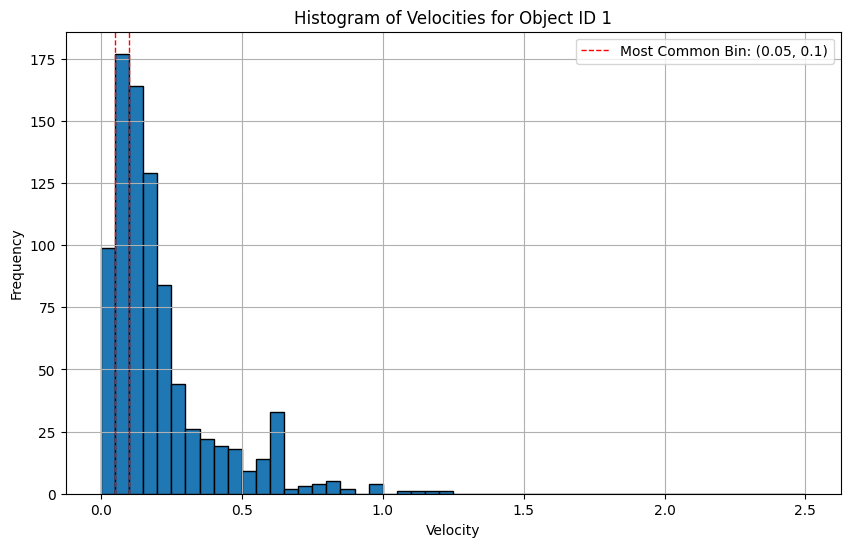

The most common velocity bin range is: (0.05, 0.1)


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your data in a pandas DataFrame named 'data'
# data = pd.read_csv('your_data_file.csv')  # Load your data file

# Filter data for Object ID 1
obj_data = data[data['Object ID'] == 1]

# Compute histogram data
counts, bin_edges = np.histogram(obj_data['Velocity'], bins=50, range=(0, 2.5))

# Find the bin with the highest count
max_count_index = np.argmax(counts)
most_common_bin_left = bin_edges[max_count_index]
most_common_bin_right = bin_edges[max_count_index + 1]
most_common_bin_range = (most_common_bin_left, most_common_bin_right)

# Plot histogram of velocities
plt.figure(figsize=(10, 6))
plt.hist(obj_data['Velocity'], bins=50, edgecolor='black', range=(0, 2.5))
plt.xlabel('Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of Velocities for Object ID 1')

# Highlight the bin with the highest count
plt.axvline(most_common_bin_left, color='r', linestyle='dashed', linewidth=1, label=f'Most Common Bin: {most_common_bin_range}')
plt.axvline(most_common_bin_right, color='r', linestyle='dashed', linewidth=1)
plt.legend()
plt.grid(True)
plt.show()

# Print the most common bin range
print(f'The most common velocity bin range is: {most_common_bin_range}')


In [15]:
obj_data['Velocity'].mean()

0.20848674224551397

In [19]:
import pandas as pd

# Load your data
data = pd.read_csv('velocity_per_frame_new.csv')

# Create a list to collect average velocity data
average_velocity_list = []

# Calculate average velocity for each object ID
for object_id in data['Object ID'].unique():
    # Filter data for the current object
    obj_data = data[data['Object ID'] == object_id]
    
    # Calculate the average velocity
    average_velocity = obj_data['Velocity'].mean()
    
    # Append the result to the list
    average_velocity_list.append({
        'Object ID': object_id,
        'Average_Velocity': average_velocity
    })

# Convert the list to a DataFrame
average_velocity_data = pd.DataFrame(average_velocity_list)

# Save the results to a CSV file if needed
average_velocity_data.to_csv('average_velocity_per_object.csv', index=False)

print(average_velocity_data)


      Object ID  Average_Velocity
0             1          0.208487
1             2          0.340067
2             3          0.466039
3             4          0.433807
4             5          0.545589
...         ...               ...
2412       4551          0.291824
2413       4552          0.445259
2414       4555          0.337741
2415       4558          0.718076
2416       4559          0.068688

[2417 rows x 2 columns]


In [3]:
data = pd.read_csv('FeMe-MaMos-MaMe-d0-0ng_tracking_data.csv')
data

,Frame,Object ID,X Center,Y Center,Velocity (m/s)
0,3.0,1,633.440132,287.977144,0.000000
1,3.0,2,768.929636,305.046997,0.000000
2,3.0,3,1476.441488,593.084968,0.000000
3,3.0,4,1501.718399,662.272302,0.000000
4,3.0,5,836.842958,220.352738,0.000000
...,...,...,...,...,...
193588,18045.0,4933,795.103702,292.614309,0.020780
193589,18045.0,4937,681.685089,696.430108,0.033542
193590,18045.0,4940,1002.644033,633.276766,0.024104
193591,18045.0,4941,1486.716574,556.487623,0.140265


In [22]:
139/4

34.75

In [39]:
obj_data = data[data['Object ID'] == 25]
obj_data

,Frame,Object ID,X Center,Y Center,Velocity


In [ ]:
Frame,Object ID,X Center,Y Center,Velocity (px/s)
,1,,0
,2,1147.7869824778165,700.0175593926401,0
,3,1712.6686200328925,464.77910930831104,0
,4,1061.0177483027112,667.3629895904533,0
,5,1644.1269325397825,718.1614298309769,0
,6,,0
,7,1820.8481691848776,589.5574613417806,0
,9,1059.306119473506,813.2237644926882,0
,10,1329.0023371490204,363.0184252116694,0
,11,1053.3087500043562,859.9028235066951,0
,12,1140.528006571818,427.7909226060464,0


In [ ]:
Min 985.757581056713,412.53100108609385

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
df = pd.read_csv('FeMe-MaMos-MaMe-d2-5ng_MOV.csv')

# Assuming the CSV file has columns named 'X Center' and 'Y Center'
x_center = df['X Center']
y_center = df['Y Center']

# Plot the data points
plt.scatter(x_center, y_center, color='blue')

# Draw a vertical line parallel to the y-axis at x = 985.757581056713
x_line = 1095.7869824778165
plt.axvline(x=x_line, color='red', linestyle='--', label='Vertical Line (x = {:.2f})'.format(x_line))
x_line2 = 1770.7869824778165
plt.axvline(x=x_line2, color='red', linestyle='--', label='Vertical Line (x = {:.2f})'.format(x_line))
# Set labels for the axes
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Set title for the plot
plt.title('Data Points from CSV')

# Optionally, add a legend
plt.legend()

# Optionally, add a grid
plt.grid(True)

# Display the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'FeMe-MaMos-MaMe-d2-5ng_MOV.csv'

In [5]:
import pandas as pd

# Load the CSV file
file_path = 'MaMe-FeMos-FeMe-d2-5ng_tracking_data.csv'
df = pd.read_csv(file_path)

# Define the x-coordinate thresholds
x_threshold_1 = 1095.7869824778165
x_threshold_2 = 1770.7869824778165

# Add a new 'part' column based on the x-coordinate
df['part'] = pd.cut(df['X Center'], 
                    bins=[-float('inf'), x_threshold_1, x_threshold_2, float('inf')], 
                    labels=[0, 1, 2])

# Save the modified DataFrame back to a CSV file
output_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV_with_parts.csv'
df.to_csv(output_path, index=False)

output_path


'FeMe-MaMos-MaMe-d2-5ng_MOV_with_parts.csv'

In [11]:
import pandas as pd

# Load the CSV file
file_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV.csv'
df = pd.read_csv(file_path)

# Define the x-coordinate thresholds
x_threshold_1 = 1095.7869824778165
x_threshold_2 = 1770.7869824778165

# Add a new 'part' column based on the x-coordinate
df['part'] = pd.cut(df['X Center'], 
                    bins=[-float('inf'), x_threshold_1, x_threshold_2, float('inf')], 
                    labels=[0, 1, 2])

# Conversion factor from px/s to m/s (replace with the correct value)
px_to_m = 0.001  # Example: 1 pixel = 0.001 meters

# Convert the 'Velocity (px/s)' column from px/s to m/s
df['Velocity (m/s)'] = df['Velocity (px/s)'] * px_to_m

# Calculate the average velocity for each object in m/s
average_velocity = df.groupby('Object ID')['Velocity (m/s)'].mean().reset_index()

# Merge the average velocity back into the main DataFrame
df = df.merge(average_velocity, on='Object ID', how='left', suffixes=('', '_avg'))

# Calculate the average of the average velocities for each part in m/s
average_velocity_per_part = df.groupby('part')['Velocity (m/s)_avg'].mean().reset_index()

# Rename columns for clarity
average_velocity_per_part.columns = ['part', 'average_of_average_velocity_m/s']

# Save the result to a CSV file
output_path = 'average_of_average_velocity_per_part_m_s.csv'
average_velocity_per_part.to_csv(output_path, index=False)

output_path


C:\Users\MAY02\AppData\Local\Temp\ipykernel_22432\761634995.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_per_part = df.groupby('part')['Velocity (m/s)_avg'].mean().reset_index()


'average_of_average_velocity_per_part_m_s.csv'

In [13]:
df = pd.read_csv('FeMe-MaMos-MaMe-d2-5ng_MOV.csv')
df


,Frame,Object ID,X Center,Y Center,Velocity (px/s)
0,3.0,1,985.757581,412.531001,0.000000
1,3.0,2,1147.786982,700.017559,0.000000
2,3.0,3,1712.668620,464.779109,0.000000
3,3.0,4,1061.017748,667.362990,0.000000
4,3.0,5,1644.126933,718.161430,0.000000
...,...,...,...,...,...
203869,18090.0,3881,1289.135880,1075.748135,65.638723
203870,18090.0,3887,1813.568151,359.366298,47.106075
203871,18090.0,3892,1050.726368,851.547256,5.327850
203872,18090.0,3893,2283.407856,771.872444,152.969080


C:\Users\MAY02\AppData\Local\Temp\ipykernel_2244\1010666806.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


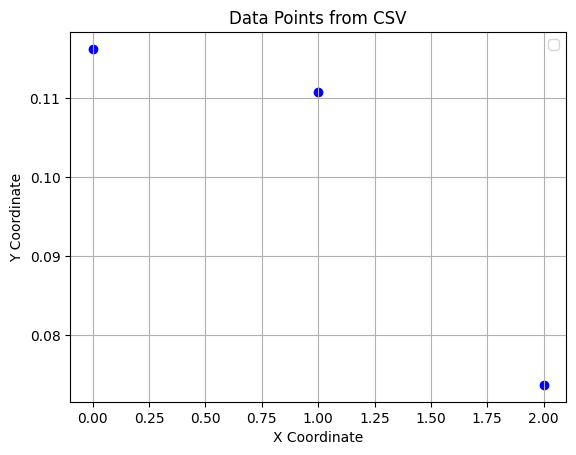

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
df = pd.read_csv('average_of_average_velocity_per_part_m_s.csv')

# Assuming the CSV file has columns named 'X Center' and 'Y Center'
p = df['part']
v = df['average_of_average_velocity_m/s']

# Plot the data points
plt.scatter(p, v, color='blue')

# Set labels for the axes
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Set title for the plot
plt.title('Data Points from CSV')

# Optionally, add a legend
plt.legend()

# Optionally, add a grid
plt.grid(True)

# Display the plot
plt.show()


In [21]:
import pandas as pd

# Load the CSV file
file_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV.csv'
df = pd.read_csv(file_path)




Initial DataFrame:
          Frame  Object ID     X Center    Y Center  Velocity (m/s)  part  \
0           1.0       5350  1219.995711  699.264649        0.000000     2   
1           1.0       5364   936.325738  319.388055        0.000000     1   
2           1.0       5407   681.626271  718.195407        0.000000     0   
3           1.0       5412   894.499242  654.182945        0.000000     1   
4           1.0       5415   837.006121  721.095321        0.000000     1   
...         ...        ...          ...         ...             ...   ...   
180143  18075.0      10370  1127.935623  700.442000        0.853903     1   
180144  18075.0      10371   813.444698  253.743995        0.068377     1   
180145  18075.0      10379   767.766337  299.611108        0.640729     1   
180146  18075.0      10380   693.698447  239.636823        0.500434     0   
180147  18075.0      10381   707.658515  667.073196        0.300003     0   

        average_velocity_by_object_id  average_velocity_

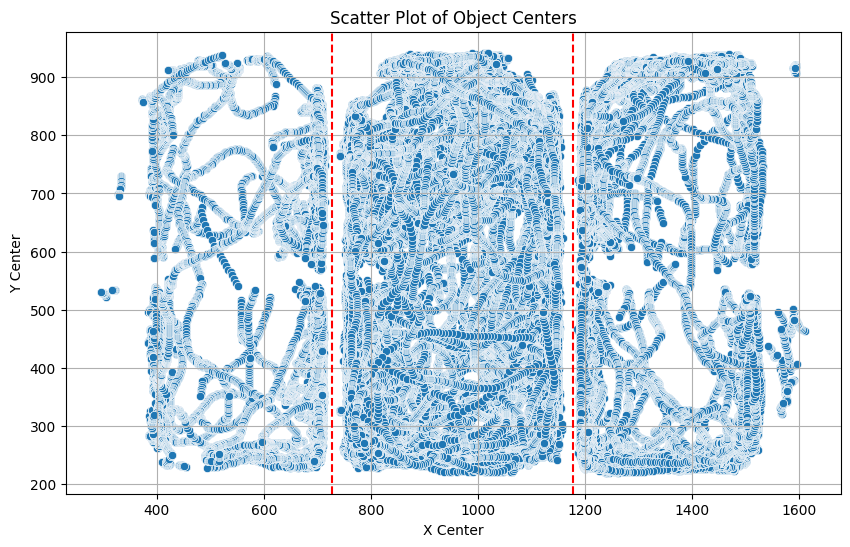

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the path to your CSV file
csv_file_path = 'MaMe-FeMos-FeMe-d2-5ng_tracking_data.csv'  # Replace with your actual file path

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the initial DataFrame
print("Initial DataFrame:")
print(df)

# Limit the DataFrame to the first 100 rows for plotting (if applicable)
df = df.head(1000000000000000000)  # Adjust the number based on your dataset size

# Example: Scatter plot of X Center vs Y Center colored by Object ID
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='X Center', y='Y Center')

plt.axvline(x=728, color='red', linestyle='--', label='X = 29')  # Vertical line at X = 29

plt.axvline(x=1177, color='red', linestyle='--', label='X = 29')  # Vertical line at X = 29

plt.title('Scatter Plot of Object Centers')
plt.xlabel('X Center')
plt.ylabel('Y Center')

plt.grid()

plt.show()




Initial DataFrame:
          Frame  Object ID     X Center    Y Center  Velocity (m/s)
0           1.0       4421  1193.683823  285.913210        0.000000
1           1.0       4547  1459.803085  496.647371        0.000000
2           1.0       4860   662.960877  274.606494        0.000000
3           1.0       4922   758.487220  286.821015        0.000000
4           1.0       4928   781.915646  236.008119        0.000000
...         ...        ...          ...         ...             ...
179844  18030.0      14067   526.431143  332.227221        0.335760
179845  18030.0      14069  1129.948297  322.665167        0.430884
179846  18030.0      14071  1214.977227  885.021752        0.152312
179847  18030.0      14074   692.760764  914.666862        0.851133
179848  18030.0      14075   689.800133  919.120238        2.045447

[179849 rows x 5 columns]


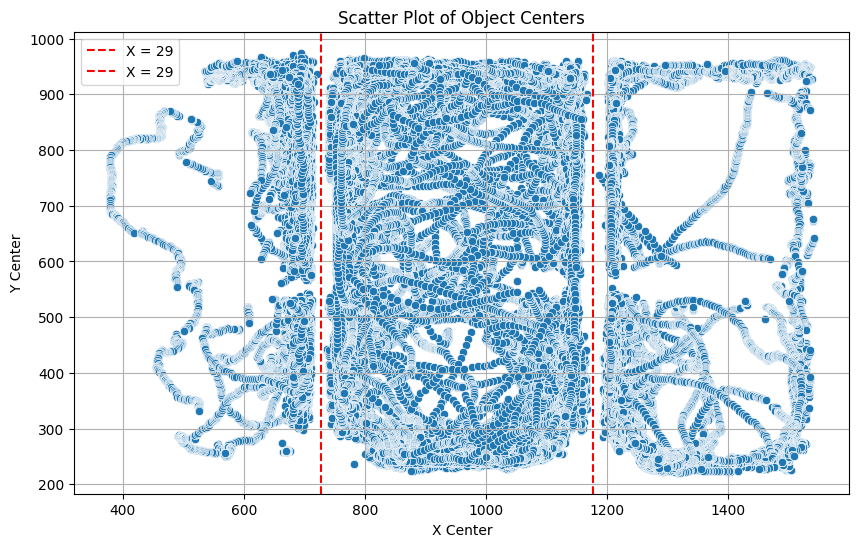

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the path to your CSV file
csv_file_path = 'FeMe-MaMos-MaMe-d2-25ng_tracking_data.csv'  # Replace with your actual file path

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the initial DataFrame
print("Initial DataFrame:")
print(df)

# Limit the DataFrame to the first 100 rows for plotting (if applicable)
df = df.head(10000000000000000000000)  # Adjust the number based on your dataset size

# Example: Scatter plot of X Center vs Y Center colored by Object ID
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='X Center', y='Y Center')
plt.axvline(x=728, color='red', linestyle='--', label='X = 29')  # Vertical line at X = 29

plt.axvline(x=1177, color='red', linestyle='--', label='X = 29')  # Vertical line at X = 29
plt.title('Scatter Plot of Object Centers')
plt.xlabel('X Center')
plt.ylabel('Y Center')

plt.grid()
plt.legend()  # Show legend for the vertical line
plt.show()


In [22]:
df

,Frame,Object ID,X Center,Y Center,Velocity (px/s)
0,3.0,1,985.757581,412.531001,0.000000
1,3.0,2,1147.786982,700.017559,0.000000
2,3.0,3,1712.668620,464.779109,0.000000
3,3.0,4,1061.017748,667.362990,0.000000
4,3.0,5,1644.126933,718.161430,0.000000
...,...,...,...,...,...
203869,18090.0,3881,1289.135880,1075.748135,65.638723
203870,18090.0,3887,1813.568151,359.366298,47.106075
203871,18090.0,3892,1050.726368,851.547256,5.327850
203872,18090.0,3893,2283.407856,771.872444,152.969080


In [ ]:
import pandas as pd
import numpy as np

# Load the CSV file
file_path = 'MaMe-FeMos-FeMe-d2-5ng_tracking_data.csv'
df = pd.read_csv(file_path)

# Define the x-coordinate thresholds
x_threshold_1 = 728
x_threshold_2 = 1177

# Add a new 'part' column based on the x-coordinate
df['part'] = pd.cut(df['X Center'], 
                    bins=[-float('inf'), x_threshold_1, x_threshold_2, float('inf')], 
                    labels=[0, 1, 2])

# Ensure that the column name matches the actual column in your CSV file
velocity_column = 'Velocity (m/s)'

# Calculate the average velocity for each object id
average_velocity_by_object_id = df.groupby(['Object ID'])[velocity_column].mean().reset_index()

# Rename columns for clarity
average_velocity_by_object_id.columns = ['Object ID', 'average_velocity_by_object_id']

# Merge the average velocity by object ID back into the original dataframe
df = pd.merge(df, average_velocity_by_object_id, on='Object ID', how='left')

# Print the DataFrame to check the columns after merging
print("DataFrame after merging average velocity by object ID:")
print(df.head())  # Display the first few rows to check

# Now, calculate the average velocity for each part by averaging the average velocities of objects within each part
# Ensure the column name is correct
print("Available columns:", df.columns)  # Print column names for verification

try:
    average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
except KeyError as e:
    print(f"KeyError: {e}")
    print("DataFrame columns at the time of error:", df.columns)

# Rename columns for clarity
average_velocity_by_part.columns = ['part', 'average_velocity_by_part']

# Merge the average velocity by part back into the original dataframe
df = pd.merge(df, average_velocity_by_part, on='part', how='left')

# Function to calculate distance between consecutive points
def calculate_distance(group):
    group = group.sort_values('Frame')
    x_diff = group['X Center'].diff()
    y_diff = group['Y Center'].diff()
    
    # Set distance to 0 where both x_diff and y_diff are NaN
    group['Distance'] = np.where(pd.isna(x_diff) & pd.isna(y_diff), 0, np.sqrt(x_diff**2 + y_diff**2) * 0.001)
    
    return group

# Apply the function to calculate distance for each Object ID group
df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)

# Calculate the total distance for each Object ID and part
total_distances = df.groupby(['Object ID', 'part'])['Distance'].sum().reset_index()

# Rename the column for clarity
total_distances.columns = ['Object ID', 'part', 'total_distance']

# Merge total distances back into the original dataframe if needed
df = pd.merge(df, total_distances, on=['Object ID', 'part'], how='left')

# Overwrite the original CSV file
df.to_csv(file_path, index=False) => open folder data and run it with all csv file

In [93]:
import pandas as pd
import numpy as np
import os

# Define the directory containing the CSV files
data_directory = 'Data'  # Replace with your folder path

# Get all CSV files in the directory
csv_files = [f for f in os.listdir(data_directory) if f.endswith('.csv')]

# Define the x-coordinate thresholds
x_threshold_1 = 728
x_threshold_2 = 1177

# Loop through each CSV file and process
for file_name in csv_files:
    file_path = os.path.join(data_directory, file_name)
    
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Add a new 'part' column based on the x-coordinate
    df['part'] = pd.cut(df['X Center'], 
                        bins=[-float('inf'), x_threshold_1, x_threshold_2, float('inf')], 
                        labels=[0, 1, 2])

    # Ensure that the column name matches the actual column in your CSV file
    velocity_column = 'Velocity (m/s)'

    # Calculate the average velocity for each object id
    average_velocity_by_object_id = df.groupby(['Object ID'])[velocity_column].mean().reset_index()

    # Rename columns for clarity
    average_velocity_by_object_id.columns = ['Object ID', 'average_velocity_by_object_id']

    # Merge the average velocity by object ID back into the original dataframe
    df = pd.merge(df, average_velocity_by_object_id, on='Object ID', how='left')

    # Now, calculate the average velocity for each part by averaging the average velocities of objects within each part
    print("Available columns:", df.columns)  # Print column names for verification

    try:
        average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
    except KeyError as e:
        print(f"KeyError: {e}")
        print("DataFrame columns at the time of error:", df.columns)

    # Rename columns for clarity
    average_velocity_by_part.columns = ['part', 'average_velocity_by_part']

    # Merge the average velocity by part back into the original dataframe
    df = pd.merge(df, average_velocity_by_part, on='part', how='left')

    # Function to calculate distance between consecutive points
    def calculate_distance(group):
        group = group.sort_values('Frame')
        x_diff = group['X Center'].diff()
        y_diff = group['Y Center'].diff()
        
        # Set distance to 0 where both x_diff and y_diff are NaN
        group['Distance'] = np.where(pd.isna(x_diff) & pd.isna(y_diff), 0, np.sqrt(x_diff**2 + y_diff**2) * 0.001)
        
        return group

    # Apply the function to calculate distance for each Object ID group
    df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)

    # Calculate the total distance for each Object ID and part
    total_distances = df.groupby(['Object ID', 'part'])['Distance'].sum().reset_index()

    # Rename the column for clarity
    total_distances.columns = ['Object ID', 'part', 'total_distance']

    # Merge total distances back into the original dataframe if needed
    df = pd.merge(df, total_distances, on=['Object ID', 'part'], how='left')

    # Overwrite the original CSV file
    df.to_csv(file_path, index=False)
    print(f"Processed {file_name} and saved the updated file.")

print("All files processed.")


Available columns: Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:69: FutureWarning: The default of observed=False

Processed FeMe-MaMos-MaMe-d0-0ng_tracking_data - Sao chép.csv and saved the updated file.
Available columns: Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:69: FutureWarning: The default of observed=False

Processed FeMe-MaMos-MaMe-d2-25ng_tracking_data.csv and saved the updated file.
Available columns: Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:69: FutureWarning: The default of observed=False

Processed FeMe-MaMos-MaMe-d2-5ng_tracking_data - Sao chép.csv and saved the updated file.
Available columns: Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:69: FutureWarning: The default of observed=False

Processed FeMe-MaMos-MaMe-d4-5ng_tracking_data - Sao chép.csv and saved the updated file.
Available columns: Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:69: FutureWarning: The default of observed=False

Processed FeMe-MaMos-MaMe-d7-5ng_tracking_data.csv and saved the updated file.
Available columns: Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:69: FutureWarning: The default of observed=False

Processed FeMe-MaMos-MaMe-Rev-5ng_tracking_data.csv and saved the updated file.
Available columns: Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:69: FutureWarning: The default of observed=False

Processed MaMe-FeMos-FeMe-d0-0ng_tracking_data.csv and saved the updated file.
Available columns: Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:69: FutureWarning: The default of observed=False

Processed MaMe-FeMos-FeMe-d2-25ng_tracking_data.csv and saved the updated file.
Available columns: Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id_x', 'average_velocity_by_part',
       'Distance', 'total_distance', 'average_velocity_by_object_id_y'],
      dtype='object')
KeyError: 'Column not found: average_velocity_by_object_id'
DataFrame columns at the time of error: Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id_x', 'average_velocity_by_part',
       'Distance', 'total_distance', 'average_velocity_by_object_id_y'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:69: FutureWarning: The default of observed=False

Processed MaMe-FeMos-FeMe-d2-5ng_tracking_data.csv and saved the updated file.
Available columns: Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:69: FutureWarning: The default of observed=False

Processed MaMe-FeMos-FeMe-d4-25ng_tracking_data.csv and saved the updated file.
Available columns: Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_velocity_by_part = df.groupby('part')['average_velocity_by_object_id'].mean().reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\2788735902.py:69: FutureWarning: The default of observed=False

Processed MaMe-FeMos-FeMe-d7-5ng_tracking_data.csv and saved the updated file.
All files processed.


In [91]:
df

,Frame,Object ID,X Center,Y Center,Velocity (m/s),part,average_velocity_by_object_id,average_velocity_by_part,Distance,total_distance
0,1.0,5350,1219.995711,699.264649,0.000000,2,0.078193,0.551178,0.000000,0.000783
1,1.0,5364,936.325738,319.388055,0.000000,1,0.027551,0.588558,0.000000,0.000276
2,1.0,5407,681.626271,718.195407,0.000000,0,0.388056,0.435265,0.000000,0.003884
3,1.0,5412,894.499242,654.182945,0.000000,1,0.353026,0.588558,0.000000,0.003534
4,1.0,5415,837.006121,721.095321,0.000000,1,0.046024,0.588558,0.000000,0.000461
...,...,...,...,...,...,...,...,...,...,...
180143,18075.0,10370,1127.935623,700.442000,0.853903,1,0.981407,0.588558,0.002849,0.085140
180144,18075.0,10371,813.444698,253.743995,0.068377,1,0.433465,0.588558,0.000228,0.034712
180145,18075.0,10379,767.766337,299.611108,0.640729,1,0.783147,0.588558,0.002138,0.023518
180146,18075.0,10380,693.698447,239.636823,0.500434,0,0.379936,0.435265,0.001670,0.008874


Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id_x', 'average_velocity_by_part_x',
       'Distance', 'total_distance_x', 'average_velocity_by_object_id_y',
       'average_velocity_by_part_y', 'total_distance_y'],
      dtype='object')


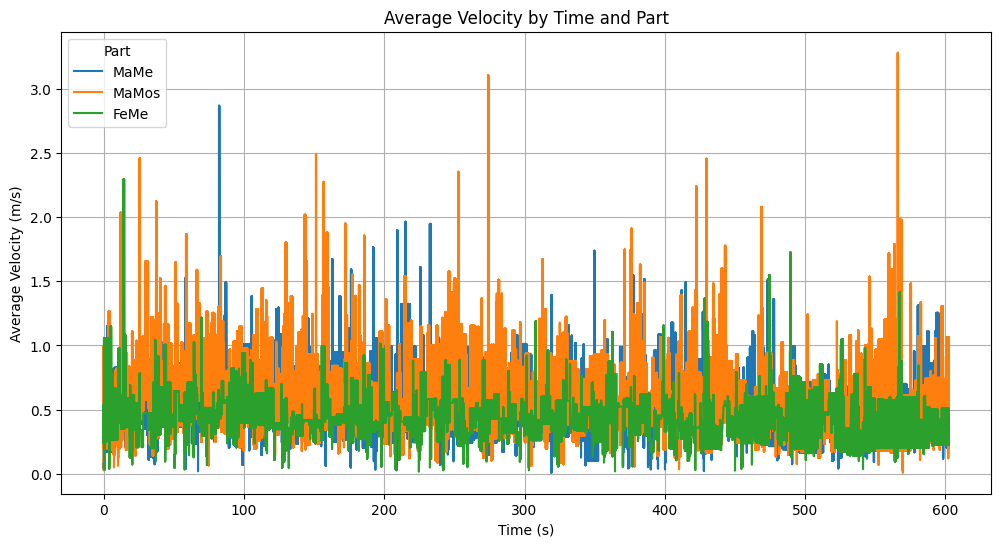

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the labels corresponding to parts
label = ['FeMe', 'MaMos', 'MaMe']

# Load the CSV file
file_path = 'Data\\MaMe-FeMos-FeMe-d2-5ng_tracking_data.csv'  # Use forward slashes or double backslashes for file paths
df = pd.read_csv(file_path)

# Print the columns to check for the correct column names
print(df.columns)

# Define the frame rate (frames per second)
frame_rate = 30  # Replace this with your actual frame rate

# Convert frame numbers to time in seconds
df['Time (s)'] = df['Frame'] / frame_rate

# Create a line plot for each part
plt.figure(figsize=(12, 6))

# Loop through each part and plot
for part in df['part'].unique():
    subset = df[df['part'] == part]
    # Adjust the column name below based on your findings
    plt.plot(subset['Time (s)'], subset['average_velocity_by_object_id_x'], label=label[int(part)])  # Convert part to int

# Adding labels and title
plt.xlabel('Time (s)')
plt.ylabel('Average Velocity (m/s)')
plt.title('Average Velocity by Time and Part')
plt.legend(title='Part')
plt.grid(True)

# Display the plot
plt.show()


In [99]:
df

,Frame,Object ID,X Center,Y Center,Velocity (m/s),part,average_velocity_by_object_id_x,average_velocity_by_part_x,Distance,total_distance_x,average_velocity_by_object_id_y,average_velocity_by_part_y,total_distance_y,Time (s)
0,1.0,5350,1219.995711,699.264649,0.000000,2,0.078193,0.551178,0.000000,0.000783,0.078193,0.488020,0.000783,0.033333
1,1.0,5364,936.325738,319.388055,0.000000,1,0.027551,0.588558,0.000000,0.000276,0.027551,0.507427,0.000276,0.033333
2,1.0,5407,681.626271,718.195407,0.000000,0,0.388056,0.435265,0.000000,0.003884,0.388056,0.513791,0.003884,0.033333
3,1.0,5412,894.499242,654.182945,0.000000,1,0.353026,0.588558,0.000000,0.003534,0.353026,0.507427,0.003534,0.033333
4,1.0,5415,837.006121,721.095321,0.000000,1,0.046024,0.588558,0.000000,0.000461,0.046024,0.507427,0.000461,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180143,18075.0,10370,1127.935623,700.442000,0.853903,1,0.981407,0.588558,0.002849,0.085140,0.981407,0.507427,0.085140,602.500000
180144,18075.0,10371,813.444698,253.743995,0.068377,1,0.433465,0.588558,0.000228,0.034712,0.433465,0.507427,0.034712,602.500000
180145,18075.0,10379,767.766337,299.611108,0.640729,1,0.783147,0.588558,0.002138,0.023518,0.783147,0.507427,0.023518,602.500000
180146,18075.0,10380,693.698447,239.636823,0.500434,0,0.379936,0.435265,0.001670,0.008874,0.379936,0.513791,0.008874,602.500000


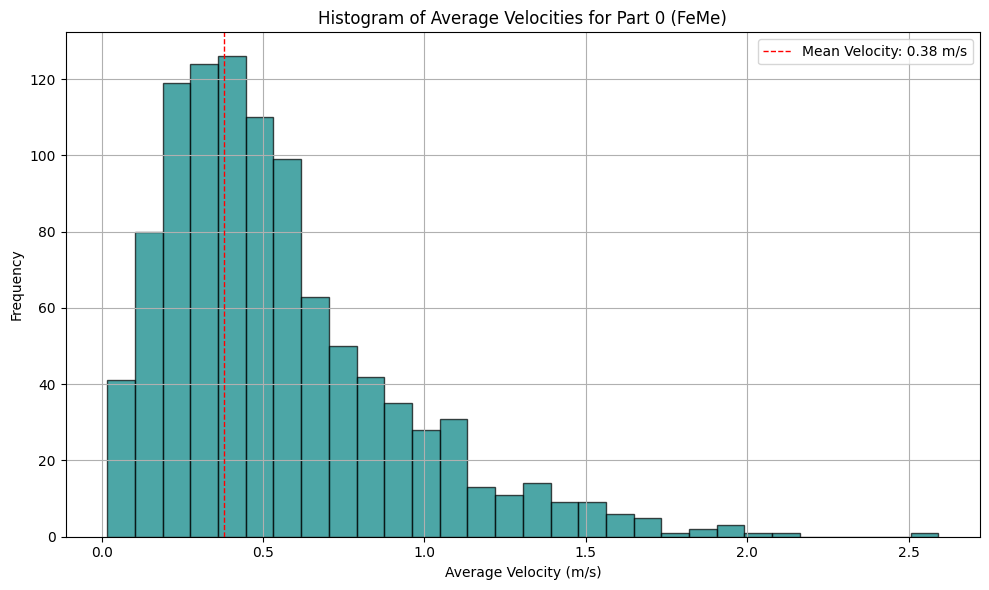

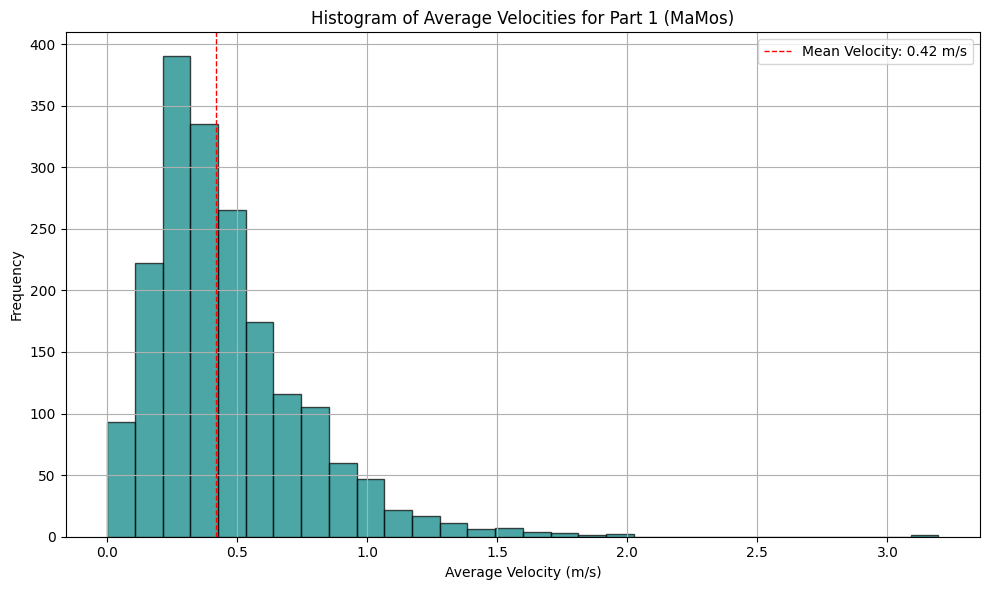

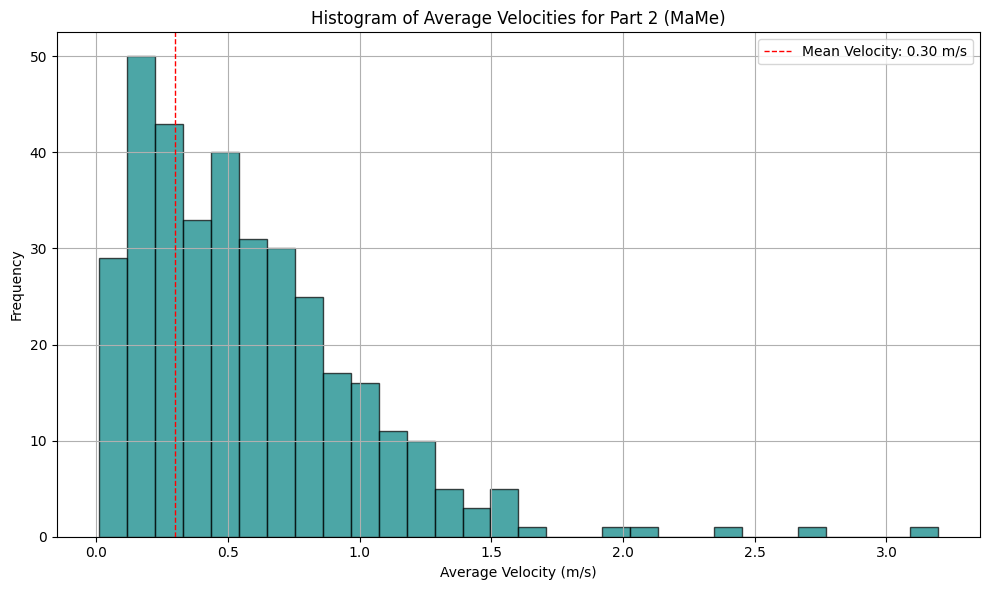

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Part labels
labels = ['FeMe', 'MaMos', 'MaMe']

# Load the updated CSV file with 'part' column
data_path = 'Data/FeMe-MaMos-MaMe-d0-0ng_tracking_data.csv'
output_folder = 'histograms'  # Specify your output folder name

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    print(f"Error: The file at {data_path} was not found.")
    exit()

for i in range(3):
    # Filter the data for the current part
    part_data = df[df['part'] == i]
    
    # Calculate the mean velocity for each object ID in the current part
    velocity_average_by_id = part_data.groupby('Object ID')['average_velocity_by_object_id'].mean().values
    
    # Calculate the mean of average velocities for the current part
    mean_velocity_part = part_data['average_velocity_by_part'].mean()
    
    # Plotting the histogram of average velocities for the current part
    plt.figure(figsize=(10, 6))
    plt.hist(velocity_average_by_id, bins=30, color='teal', edgecolor='black', alpha=0.7)
    plt.axvline(mean_velocity_part, color='red', linestyle='dashed', linewidth=1, label=f'Mean Velocity: {mean_velocity_part:.2f} m/s')
    plt.xlabel('Average Velocity (m/s)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Average Velocities for Part {i} ({labels[i]})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save each histogram as a separate PNG file in the specified folder
    plt.savefig(os.path.join(output_folder, f'histogram_average_velocity_part_{i}_{labels[i]}.png'))
    plt.show()  # Display the plot for the current part


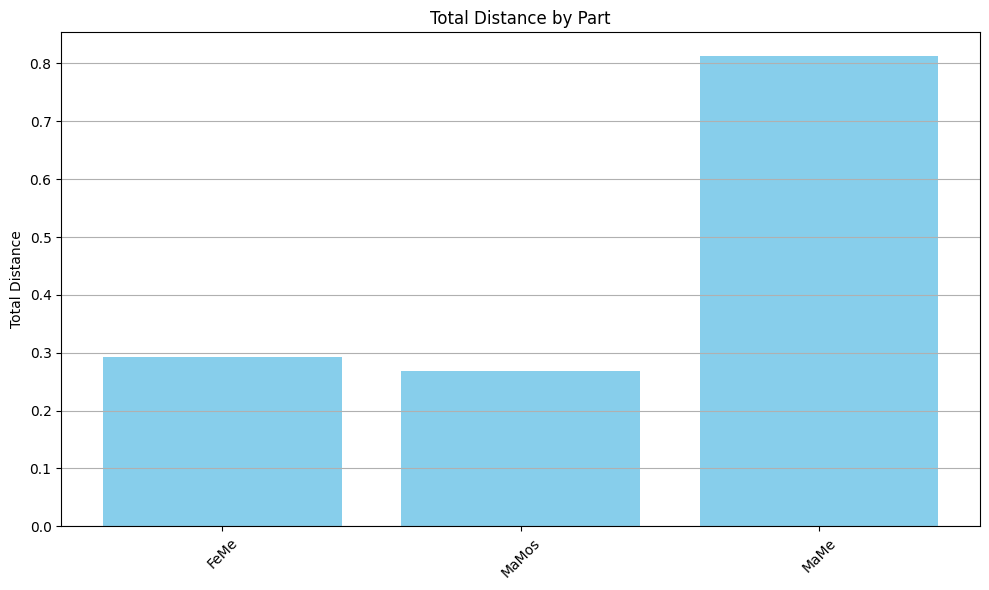

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
labels = ['FeMe', 'MaMos', 'MaMe']
# Load the CSV file
# C:\Users\Admin\Desktop\FishTracking-\Data\FeMe-MaMos-MaMe
df = pd.read_csv('Data\FeMe-MaMos-MaMe\FeMe-MaMos-MaMe-d0-0ng_tracking_data.csv')

# Group by 'part' and sum 'total_distance'
total_distance_by_part = df.groupby('part')['total_distance'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, total_distance_by_part['total_distance'], color='skyblue')
plt.ylabel('Total Distance')
plt.title('Total Distance by Part')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [172]:
A = df.groupby('part')['total_distance']
         

In [177]:
A.head()

0     0.397968
1     0.101416
2     1.155572
3     0.539382
4     0.290355
5     0.832580
6     0.196860
7     0.030608
8     0.018821
9     0.397968
11    1.155572
12    0.539382
18    0.397968
27    0.397968
36    0.397968
Name: total_distance, dtype: float64

In [157]:
total_distance_by_part

array([0.39796832, 0.10141629, 1.15557178, ..., 0.02103033, 0.0047847 ,
       0.02017255])

In [142]:
velocity_average_by_id['average_velocity_by_object_id']

IndexError: Column(s) average_velocity_by_object_id already selected

In [135]:
velocity_average_by_id =average_velocity_with_part.groupby('Object ID')['average_velocity_by_object_id']


In [136]:
velocity_average_by_id.head()

0         0.132671
1         0.349362
2         0.161457
3         0.117995
4         0.185939
            ...   
193204    0.157570
193205    0.286795
193206    0.159098
193218    0.159098
193229    0.159098
Name: average_velocity_by_object_id, Length: 15849, dtype: float64

In [118]:
part_0_data['average_velocity_by_object_id']

0         0.132671
9         0.132671
18        0.132671
27        0.132671
36        0.132671
            ...   
193578    0.490599
193581    0.159098
193584    0.115506
193589    0.490599
193592    0.159098
Name: average_velocity_by_object_id, Length: 49897, dtype: float64

In [112]:
part_0_data 

,Frame,Object ID,X Center,Y Center,Velocity (m/s),part,average_velocity_by_object_id,average_velocity_by_part,Distance,total_distance
0,3.0,1,633.440132,287.977144,0.000000,0,0.132671,0.380443,0.000000,0.397968
9,4.0,1,633.930447,287.940002,0.147369,0,0.132671,0.380443,0.000492,0.397968
18,5.0,1,633.923814,287.132729,0.241948,0,0.132671,0.380443,0.000807,0.397968
27,6.0,1,633.622462,287.421757,0.125141,0,0.132671,0.380443,0.000418,0.397968
36,7.0,1,633.580279,287.442394,0.014074,0,0.132671,0.380443,0.000047,0.397968
...,...,...,...,...,...,...,...,...,...,...
193578,18044.0,4937,681.589224,696.372352,0.018564,0,0.490599,0.380443,0.000062,0.090033
193581,18044.0,4943,680.072311,615.954674,0.062594,0,0.159098,0.380443,0.000209,0.020173
193584,18045.0,4860,662.989058,274.645704,0.054712,0,0.115506,0.380443,0.000183,0.251670
193589,18045.0,4937,681.685089,696.430108,0.033542,0,0.490599,0.380443,0.000112,0.090033


In [110]:
 part_0_data['average_velocity_by_object_id']

0         0.132671
9         0.132671
18        0.132671
27        0.132671
36        0.132671
            ...   
193578    0.490599
193581    0.159098
193584    0.115506
193589    0.490599
193592    0.159098
Name: average_velocity_by_object_id, Length: 49897, dtype: float64

(array([       1671,       11349,        8600,        7747,       13625,        8731,        9656,        3194,        1021,         540,         507,         368,          90,         156,          58,          26,          99,          31,          45,          27,          53,          48,          55,           0,
                  0,          29,          23,           0,           0,           7,           0,           5,          55,          17,           0,           0,           0,           9,          12,           0,           0,          11,           0,           0,          12,          12,           0,           0,
                  0,           0,           0,           0,           0,           0,           0,           0,           0,           6,           0,           0,           0,           6,           0,           0,           0,           0,           0,           0,           0,           9,           0,           0,
                  0,           0,       

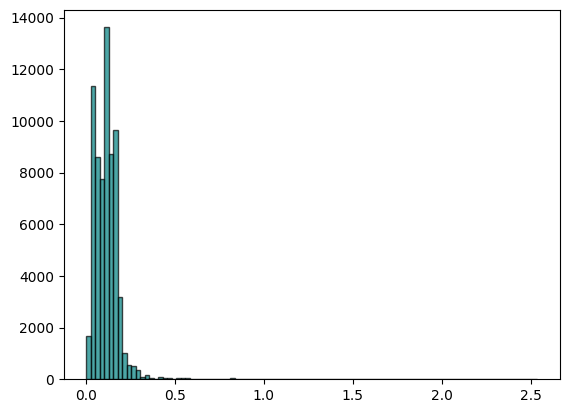

In [82]:
plt.hist(, bins=100, color='teal', edgecolor='black', alpha=0.7)


In [94]:
df1

,Frame,Object ID,X Center,Y Center,Velocity (px/s),part,Velocity (m/s),Velocity (m/s)_avg
0,3.0,1,985.757581,412.531001,0.000000,0,0.000000,0.026816
1,3.0,2,1147.786982,700.017559,0.000000,1,0.000000,0.114825
2,3.0,3,1712.668620,464.779109,0.000000,1,0.000000,0.051660
3,3.0,4,1061.017748,667.362990,0.000000,0,0.000000,0.113965
4,3.0,5,1644.126933,718.161430,0.000000,1,0.000000,0.129423
...,...,...,...,...,...,...,...,...
203869,18090.0,3881,1289.135880,1075.748135,65.638723,1,0.065639,0.018435
203870,18090.0,3887,1813.568151,359.366298,47.106075,2,0.047106,0.040233
203871,18090.0,3892,1050.726368,851.547256,5.327850,0,0.005328,0.083212
203872,18090.0,3893,2283.407856,771.872444,152.969080,2,0.152969,0.126048


In [70]:
df1 = pd.read_csv('average_velocity_with_part.csv')
df1

,Frame,Object ID,X Center,Y Center,Velocity (px/s),part,Velocity (m/s),Velocity (m/s)_avg
0,3.0,1,985.757581,412.531001,0.000000,0,0.000000,0.026816
1,3.0,2,1147.786982,700.017559,0.000000,1,0.000000,0.114825
2,3.0,3,1712.668620,464.779109,0.000000,1,0.000000,0.051660
3,3.0,4,1061.017748,667.362990,0.000000,0,0.000000,0.113965
4,3.0,5,1644.126933,718.161430,0.000000,1,0.000000,0.129423
...,...,...,...,...,...,...,...,...
203869,18090.0,3881,1289.135880,1075.748135,65.638723,1,0.065639,0.018435
203870,18090.0,3887,1813.568151,359.366298,47.106075,2,0.047106,0.040233
203871,18090.0,3892,1050.726368,851.547256,5.327850,0,0.005328,0.083212
203872,18090.0,3893,2283.407856,771.872444,152.969080,2,0.152969,0.126048


In [83]:
# Step 1: Filter the DataFrame where 'part' is 2 and 'Velocity (m/s)' is 0
df = df1[(df1['part'] == 0)]

# Step 2: Remove rows where 'Velocity (m/s)' is 0 if 'Frame' is not 3
df = df[~((df['Frame'] != 3) & (df['Velocity (m/s)'] == 0))]

df2 = df[(df['Velocity (m/s)'] == 0)]
df1

,Frame,Object ID,X Center,Y Center,Velocity (px/s),part,Velocity (m/s),Velocity (m/s)_avg
0,3.0,1,985.757581,412.531001,0.000000,0,0.000000,0.026816
1,3.0,2,1147.786982,700.017559,0.000000,1,0.000000,0.114825
2,3.0,3,1712.668620,464.779109,0.000000,1,0.000000,0.051660
3,3.0,4,1061.017748,667.362990,0.000000,0,0.000000,0.113965
4,3.0,5,1644.126933,718.161430,0.000000,1,0.000000,0.129423
...,...,...,...,...,...,...,...,...
203869,18090.0,3881,1289.135880,1075.748135,65.638723,1,0.065639,0.018435
203870,18090.0,3887,1813.568151,359.366298,47.106075,2,0.047106,0.040233
203871,18090.0,3892,1050.726368,851.547256,5.327850,0,0.005328,0.083212
203872,18090.0,3893,2283.407856,771.872444,152.969080,2,0.152969,0.126048


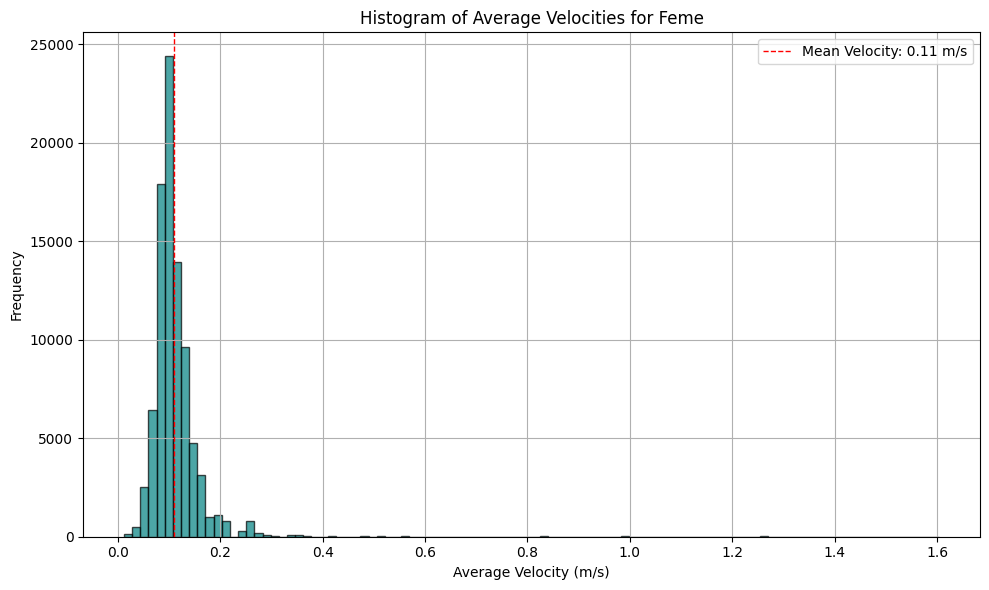

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated CSV file with 'part' column
average_velocity_with_part_path = 'average_velocity_with_part.csv'
average_velocity_with_part = pd.read_csv(average_velocity_with_part_path)

# Filter the data to include only objects in Part 0
part_0_data = average_velocity_with_part[average_velocity_with_part['part'] == 1]
# part_0_data = df

mean_velocity_part_0 = part_0_data['Velocity (m/s)_avg'].mean()

# Plotting the histogram of average velocities for Part 0
plt.figure(figsize=(10, 6))
plt.hist(part_0_data['Velocity (m/s)_avg'], bins=100, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(mean_velocity_part_0, color='red', linestyle='dashed', linewidth=1, label=f'Mean Velocity: {mean_velocity_part_0:.2f} m/s')
plt.xlabel('Average Velocity (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Velocities for Feme')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Test_mean.png')
plt.show()


In [99]:
import pandas as pd
import numpy as np

# Load your DataFrame (assuming you've already read the data into `df`)
df = pd.read_csv('average_velocity_with_part.csv')

# Function to calculate distance between consecutive points
def calculate_distance(group):
    group = group.sort_values('Frame')
    x_diff = group['X Center'].diff()
    y_diff = group['Y Center'].diff()
    
    # Set distance to 0 where both x_diff and y_diff are NaN
    group['Distance'] = np.where(pd.isna(x_diff) & pd.isna(y_diff), 0, np.sqrt(x_diff**2 + y_diff**2) * 0.001)
    
    return group

# Apply the function to calculate distance for each Object ID group
df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)

# Calculate the total distance for each Object ID and part
total_distances = df.groupby(['Object ID', 'part'])['Distance'].sum().reset_index()

# Rename the column for clarity
total_distances.rename(columns={'Distance': 'Total Distance (m)'}, inplace=True)

# Show the result
total_distances


C:\Users\MAY02\AppData\Local\Temp\ipykernel_22432\3464088341.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Object ID', group_keys=False).apply(calculate_distance)


,Object ID,part,Total Distance (m)
0,1,0,0.736395
1,2,0,0.088402
2,2,1,0.283236
3,3,1,0.113766
4,4,0,0.285197
...,...,...,...
1410,3886,0,0.012999
1411,3887,2,0.053697
1412,3892,0,0.055530
1413,3893,2,0.067293


In [106]:
part_0_data = total_distances[total_distances['part'] == 0]
part_0_data

,Object ID,part,Distance
0,1,0,0.736395
1,2,0,0.088402
4,4,0,0.285197
8,9,0,0.389523
10,11,0,1.125492
...,...,...,...
1402,3866,0,0.257077
1406,3875,0,0.125772
1408,3882,0,0.291938
1410,3886,0,0.012999


In [115]:
part_1_data = total_distances[total_distances['part'] == 0]
part_1_data['Distance'].mean()

0.4393946098852962

In [116]:
part_1_data['Distance']

0       0.736395
1       0.088402
4       0.285197
8       0.389523
10      1.125492
          ...   
1402    0.257077
1406    0.125772
1408    0.291938
1410    0.012999
1412    0.055530
Name: Distance, Length: 605, dtype: float64

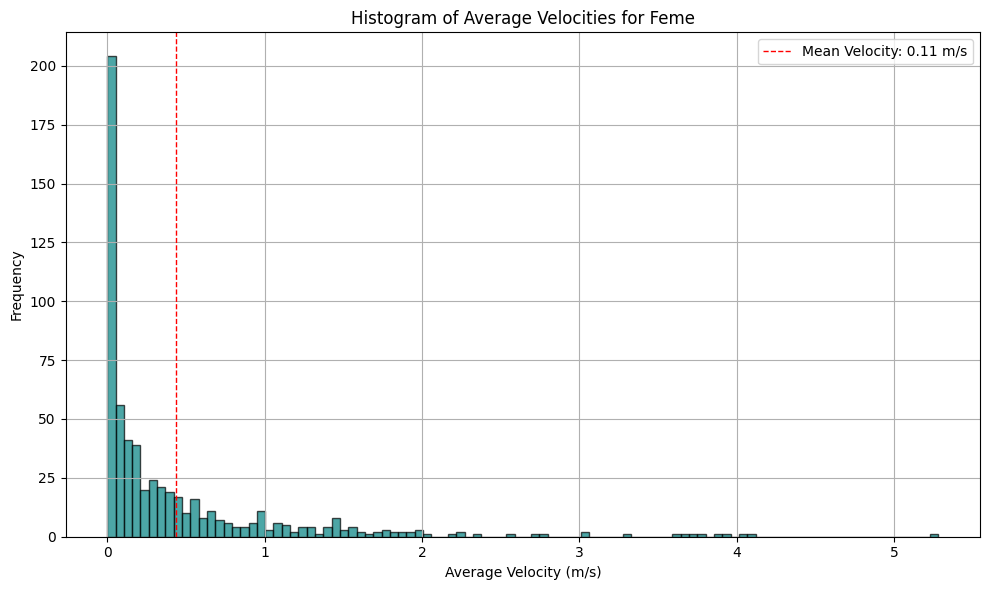

In [113]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the histogram of average velocities for Part 0
plt.figure(figsize=(10, 6))
plt.hist(part_0_data['Distance'], bins=100, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(part_0_data['Distance'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean Velocity: {mean_velocity_part_0:.2f} m/s')
plt.xlabel('Average Velocity (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Velocities for Feme')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Test_Distance.png')
plt.show()


In [ ]:
total1 = df[]

In [ ]:
df['Distance'][]

In [93]:
a = df['X Center'].diff()
a


0                 NaN
1          162.029401
2          564.881638
3         -651.650872
4          583.109184
             ...     
203869     243.823761
203870     524.432271
203871    -762.841783
203872    1232.681488
203873   -1040.946961
Name: X Center, Length: 203874, dtype: float64

,Frame,Object ID,X Center,Y Center,Velocity (px/s),part,Velocity (m/s),Velocity (m/s)_avg,Distance
4,3.0,5,1644.126933,718.161430,0.000000,1,0.000000,0.129423,NaN
15,4.0,5,1644.413080,717.531669,20.730924,1,0.020731,0.129423,0.000692
26,5.0,5,1644.686720,716.119069,43.122659,1,0.043123,0.129423,0.001439
38,6.0,5,1644.977849,715.344186,24.808249,1,0.024808,0.129423,0.000828
50,7.0,5,1645.509130,715.005120,18.888827,1,0.018889,0.129423,0.000630
...,...,...,...,...,...,...,...,...,...
8051,721.0,5,1215.675535,1313.221915,79.705715,1,0.079706,0.129423,0.002660
8061,722.0,5,1217.954219,1314.593270,79.705715,1,0.079706,0.129423,0.002660
8071,723.0,5,1220.232903,1315.964625,79.705715,1,0.079706,0.129423,0.002660
8081,724.0,5,1222.511587,1317.335980,79.705715,1,0.079706,0.129423,0.002660


In [23]:
import pandas as pd

# Load the original CSV with average velocities of each object
average_velocity_path = 'average_velocity_per_object.csv'
average_velocity = pd.read_csv(average_velocity_path)

# Load the original CSV with the full data to get the 'part' information
full_data_path = 'FeMe-MaMos-MaMe-d2-5ng_MOV.csv'
full_data = pd.read_csv(full_data_path)

# Ensure the 'part' column exists in the full_data DataFrame
# If 'part' is not in full_data, recalculate it using the thresholds
if 'part' not in full_data.columns:
    x_threshold_1 = 1095.7869824778165
    x_threshold_2 = 1770.7869824778165
    full_data['part'] = pd.cut(full_data['X Center'], 
                               bins=[-float('inf'), x_threshold_1, x_threshold_2, float('inf')], 
                               labels=[0, 1, 2])

# Merge the average velocity DataFrame with the 'part' information
average_velocity_with_part = full_data[['Object ID', 'part']].drop_duplicates().merge(
    average_velocity, 
    on='Object ID', 
    how='right'
)

# Save the updated DataFrame with the 'part' column to a new CSV file
updated_average_velocity_path = 'average_velocity_per_object_with_part.csv'
average_velocity_with_part.to_csv(updated_average_velocity_path, index=False)

updated_average_velocity_path


'average_velocity_per_object_with_part.csv'

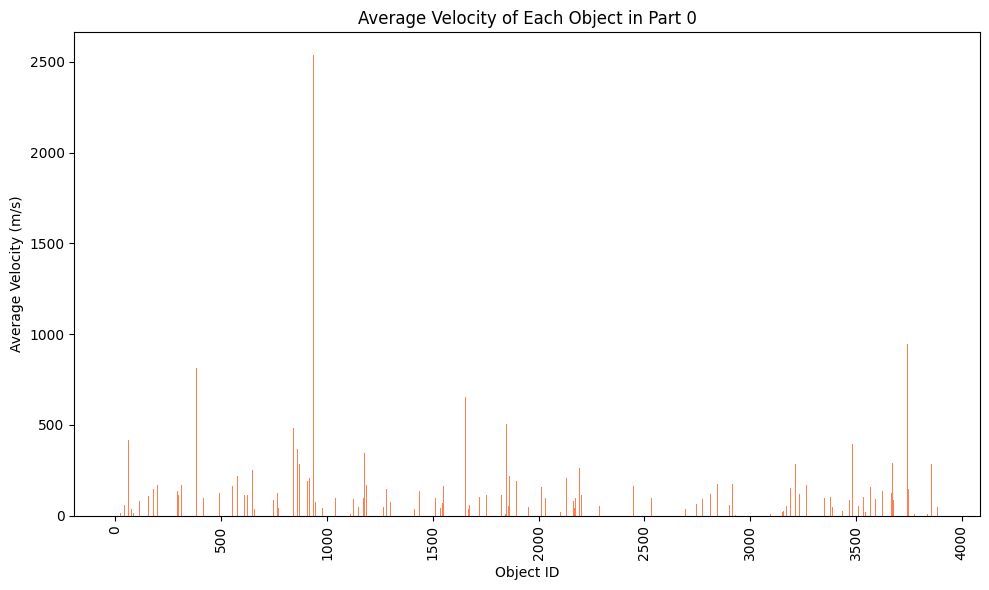

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated CSV file with 'part' column
average_velocity_with_part_path = 'average_velocity_per_object_with_part.csv'
average_velocity_with_part = pd.read_csv(average_velocity_with_part_path)

# Filter the data to include only objects in Part 0
part_0_data = average_velocity_with_part[average_velocity_with_part['part'] == 0]

# Plotting the average velocities for Part 0
plt.figure(figsize=(10, 6))
plt.bar(part_0_data['Object ID'], part_0_data['average_velocity'], color='coral')
plt.xlabel('Object ID')
plt.ylabel('Average Velocity (m/s)')
plt.title('Average Velocity of Each Object in Part 0')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('average_velocity_part_0.png')
plt.show()


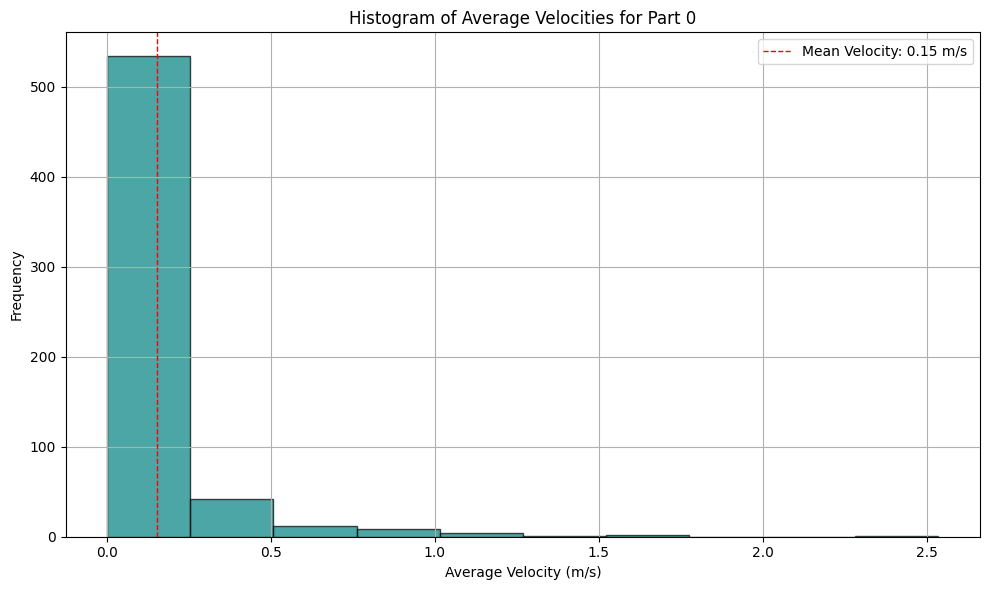

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated CSV file with 'part' column
average_velocity_with_part_path = 'average_velocity_per_object_with_part.csv'
average_velocity_with_part = pd.read_csv(average_velocity_with_part_path)

# Filter the data to include only objects in Part 0
part_0_data = average_velocity_with_part[average_velocity_with_part['part'] == 0]

# Calculate the mean of average velocities for Part 0
mean_velocity_part_0 = part_0_data['average_velocity'].mean()*0.001

# Plotting the histogram of average velocities for Part 0
plt.figure(figsize=(10, 6))
plt.hist(part_0_data['average_velocity']*0.001, bins=10, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(mean_velocity_part_0, color='red', linestyle='dashed', linewidth=1, label=f'Mean Velocity: {mean_velocity_part_0:.2f} m/s')
plt.xlabel('Average Velocity (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Velocities for Part 0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('histogram_average_velocity_part_0_with_mean.png')
plt.show()


In [59]:
part_0_data['average_velocity']

0        26.816274
2       114.824832
4       113.964640
8       194.566857
10      100.389944
           ...    
1402     58.813781
1406     40.099814
1409    158.485724
1410     48.699393
1412     83.211987
Name: average_velocity, Length: 605, dtype: float64

KeyError: 'Object ID'

In [38]:
hist(part_0_data['average_velocity'])